# Dissertation - Data Science Project
This is the full code used for the BASC0024 Final Year Dissertation module. The topic of the dissertation is the gamification of online brokerage applications.

## 1. Importing data and libraries

In [1]:
# importing libraries
import gensim
import nltk
import spacy
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and gui

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [3]:
df = pd.read_csv('trading_ads.csv') # import the dataset

Below is an exerpt of the unedited original dataset, which had been manually collated from online sources.

In [4]:
df.head() # a preview of the dataset used

,company,url,text
0,robinhood,https://robinhood.com/us/en,Investing for Everyone. Commission-free invest...
1,robinhood,https://robinhood.com/us/en/about-us,"At Robinhood Markets, our values are in servic..."
2,etoro,https://go.etoro.com/en/stock-investing-commun...,"Invest better, together with the world’s leadi..."
3,etoro,https://go.etoro.com/en/stock-investing-commun...,Invest in the brands YOU love. Whether you’re ...
4,etoro,https://go.etoro.com/en/stock-investing-commun...,How to buy stocks without paying commission. L...


In [24]:
# companies included in the dataset
list(df['company'].unique())

['robinhood', 'etoro', 'freetrade', 'trading212', 'e*trade', 'webull']

## 2. Data preprocessing

Now we move on to the data preprocessing. Below we create a new dataframe (evquivalent to a table), such that each company is a row and is assigned one long paragraph of text that contains all of the advertisements it has used - we store this table in the variable "company_df".

In [5]:
company_df = df.groupby(['company'])['text'].apply(','.join).reset_index()
company_df.head() # preview of company_df

,company,text
0,e*trade,"Don’t wait to invest, open an account today wi..."
1,etoro,"Invest better, together with the world’s leadi..."
2,freetrade,Invest. Commission-free. Investing is one of t...
3,robinhood,Investing for Everyone. Commission-free invest...
4,trading212,Go ahead — skip this ad. Those fat-cat commiss...


In [6]:
# a list of paragraphs, where eah paragraph is all the text used by one unique company
raw_text = list(company_df['text'])

# removing urls, which should not be considered as words, from the text
text = [re.sub(r'http\S+', '', string) for string in raw_text]

### 2.1 Reducing the dataset

It is essential to reduce the complexity and extraneous information in the text using text preprocessing techniques, to make the findings more concise and informative. We also remove stop words, which are words that do not provide additional meaning, such as "in", "to", etc... as well as the company names from the dataset to reduce noise.

In [7]:
stemmer = SnowballStemmer("english") # algorithm for stemming

# add the company names as stop words
newStopWords = set(['robinhood','freetrade', 'etoro', 'trading212', 'e-trade', 'etrade', 'e*trade','webull'])
stopwords = gensim.parsing.preprocessing.STOPWORDS.union(newStopWords)

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# preprocessing data: tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

The variable "preprocessed_docs" contains a list of lists, the outer list being the company and the innter list being the preprocessed words.

In [8]:
processed_docs = [] # variable which will contain a list of each text entry that has been preprocessed

for doc in text:
    processed_docs.append(preprocess(doc))
#each doc is a company

processed_docs[1][:5]

['invest', 'better', 'world', 'lead', 'trade']

### 2.2 Bag-of-Words (BoW) Model
We use the cleaned dataset to create a BoW model, which  is a statistical language model that is based on word count. It is necessary for more sophisticated NLP techniques we will be employing later on, such as topic modelling.

In [9]:
'''
Create the Bag-of-words model for each document (text from each company)
dictionary maps the string representation of a word to its corresponding number
'bow_corpus' is a list of dictionaries: For each document we create another dictionary reporting how many words there are (keys) and how many times those words appear (values). 
'''
dictionary = gensim.corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


In [10]:
# Illustration of the BoW model
# for the first company, word 0 appears 13 times, word 1 appears 1 time, etc
bow_corpus[0][:5]

[(0, 13), (1, 1), (2, 1), (3, 1), (4, 1)]

In [11]:
'''
We can now preview BoW for our sample preprocessed document (noting that we have now separated our dataset into subsets by company)
document_num is an index that keeps track of which company we are looking at
For example if document_num = 0, we have the BoW model of the first company (Python numbering starts from 0)
'''
document_num = 0
bow_doc_x = bow_corpus[document_num]

n=0
for i in range(len(bow_doc_x)):
    if bow_doc_x[i][1]>3 and n<15:
        print("Word {} (\"{}\") appears {} time(s).".format(bow_doc_x[i][0], 
                                                    dictionary[bow_doc_x[i][0]], 
                                                    bow_doc_x[i][1]))
        n+=1

Word 0 ("account") appears 13 time(s).
Word 6 ("award") appears 4 time(s).
Word 29 ("commiss") appears 7 time(s).
Word 34 ("contract") appears 4 time(s).
Word 45 ("dream") appears 11 time(s).
Word 47 ("earn") appears 4 time(s).
Word 49 ("easi") appears 6 time(s).
Word 63 ("financi") appears 4 time(s).
Word 71 ("futur") appears 4 time(s).
Word 87 ("help") appears 4 time(s).
Word 100 ("invest") appears 23 time(s).
Word 101 ("investor") appears 4 time(s).
Word 125 ("market") appears 5 time(s).
Word 127 ("minimum") appears 5 time(s).
Word 129 ("money") appears 6 time(s).


## 3. Textual Similarity
Using spaCy's prepackages models, the similarity between two corpuora (or "chunks") of text can be computed. This is based on the transformation of text to a numerical vector representation, and then computing the vector distance between two representations. Smaller distances suggest a higher similarity.

### 3.1 Similarity between companies
First, the text is classified on the company that it belongs to, and the similarity between the text of different companies is computed.

In [12]:
# Load the spacy model en_core_web_md
nlp = spacy.load('en_core_web_md')

In [13]:
company_nlps = []
for company_text in company_df['text'].tolist():
    company_nlps.append(nlp(company_text))
    

In [14]:
similarity_matrix = []

for i in range(len(company_nlps)):
    sublist=[]
    for j in range(len(company_nlps)):
        sublist.append(company_nlps[i].similarity(company_nlps[j]))
    similarity_matrix.append(sublist)

In [16]:
company_names = company_df['company'].to_list()

In [17]:
confusion_df = pd.DataFrame(similarity_matrix, columns = company_names, index=company_names)
confusion_df

,e*trade,etoro,freetrade,robinhood,trading212,webull
e*trade,1.000000,0.987187,0.991490,0.988306,0.982421,0.976067
etoro,0.987187,1.000000,0.990037,0.979937,0.990672,0.984539
freetrade,0.991490,0.990037,1.000000,0.985991,0.990823,0.982183
robinhood,0.988306,0.979937,0.985991,1.000000,0.976259,0.965565
trading212,0.982421,0.990672,0.990823,0.976259,1.000000,0.983847
webull,0.976067,0.984539,0.982183,0.965565,0.983847,1.000000


In [18]:
def colour_df(styler):
    styler.background_gradient(axis=None,cmap="BuPu")
    return styler
    
confusion_df.style.pipe(colour_df)


,e*trade,etoro,freetrade,robinhood,trading212,webull
e*trade,1.000000,0.987187,0.991490,0.988306,0.982421,0.976067
etoro,0.987187,1.000000,0.990037,0.979937,0.990672,0.984539
freetrade,0.991490,0.990037,1.000000,0.985991,0.990823,0.982183
robinhood,0.988306,0.979937,0.985991,1.000000,0.976259,0.965565
trading212,0.982421,0.990672,0.990823,0.976259,1.000000,0.983847
webull,0.976067,0.984539,0.982183,0.965565,0.983847,1.000000


In [25]:
# saving as an excel document
# confusion_df.to_excel('company_similarity.xlsx')

Above is the final matrix that shows how similar each company's textual data is to others.

### 3.2 Similarity to aspiration words
We compile a list that we deemed was "representative" of commonly used aspiration words. We transform that list to a vector representation to be able to compute the similarity between the dataset text and the representation of aspiration words.

In [ ]:
aspiration_words = ['start','dream','power','want','build','today','wait','retir'] # note that we already remove suffixes and prefixes to reduce dimensionality
 # words we consider representative of aspirations

In [ ]:
all_words=[]
for company in bow_corpus:
    for i in range(len(company)):
        word=dictionary[company[i][0]]
        all_words.append(word)


In [ ]:
# removing stopwords
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
all_words_filtered = [word for word in all_words if word not in stops]

# convert each word in the full dataset to spacy nlp object which has a word embedding
all_words_nlp = [nlp(word) for word in all_words_filtered]

In [ ]:
# create spacy nlp object (vector respresentation) that represents aspiration words
aspiration_nlp = nlp((' ').join(aspiration_words))

In [ ]:
word_similarity = [word_nlp.similarity(aspiration_nlp) for word_nlp in all_words_nlp]

In [ ]:
word_similarity_dict = {}
for i in range(len(all_words_filtered)):
    word_similarity_dict[all_words_filtered[i]]=word_similarity[i]

In [ ]:
fig = go.Figure(data=[go.Histogram(x=word_similarity,marker_color='rgb(95, 70, 144)')])

fig.update_layout(
    title="Distribution of Similarity to Aspiration Words",
    xaxis_title="Similarity Score",
    yaxis_title="Word Frequency",
    width=1100,
    height=400
)
# fig.write_image('similarity_aspiration.png', scale=2)

fig.show()

Most of the words are positively similar, which suggests that there is a generally present link to aspirations 

### 3.3 Similarity to investing
Using the same process as when computing the similarity to aspiration words (see 3.2), similairty to the term "invest" is calculated.

In [ ]:
invest_nlp = nlp('invest')
invest_word_similarity = [word_nlp.similarity(invest_nlp) for word_nlp in all_words_nlp]

fig = go.Figure(data=[go.Histogram(x=invest_word_similarity,marker_color='rgb(95, 70, 144)')])

fig.update_layout(
    title="Distribution of Similarity to 'invest'",
    xaxis_title="Similarity Score",
    yaxis_title="Word Frequency",
    legend_title="Legend Title",
    width=1100,
    height=400
)
# fig.write_image('similarity_invest.png', scale=2)

fig.show()

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

[W008] Evaluating Doc.similarity based on empty vectors.



## 4. Keyword Statistics

### 4.1 Word Frequencies
#### 4.1.1 Plotting Histograms
This following code plots a simple stacked histogram of the most frequently used words by company.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

"freq_df" is a dataframe (table) that stores the number of times each word is used by each company, to be able to plot the  word frequency histogram

In [ ]:
# creating the dataframe for the stacked histogram
freq_df = pd.DataFrame()
j=0

for company in bow_corpus:
    freq_counts = {}
    print('Running...')
    for i in range(len(company)):
        word=dictionary[company[i][0]]
        count=company[i][1]
        if word not in freq_counts.keys():
            freq_counts[word]=count
        else:
            freq_counts[word]+=count
    comp_df = pd.DataFrame.from_dict(freq_counts, orient='index', columns=company_df['company'].iloc[[j]])
    freq_df = freq_df.join(comp_df, how='outer')
    j+=1

freq_df.fillna(0, inplace=True)
freq_df = freq_df.reset_index()
freq_df = freq_df.rename(columns={'index':'word'})
freq_df['total'] = freq_df.sum(axis=1, numeric_only=True)



Running...
Running...
Running...
Running...
Running...
Running...


In [ ]:
# we only keep words that appear more than 6 times to remove infrequent words and reduce the size of the histigram
filtered_freq_df = freq_df[freq_df['total']>=7]

In [ ]:
filtered_freq_df.head()

,word,e*trade,etoro,freetrade,robinhood,trading212,webull,total
1,access,0.0,1.0,0.0,0.0,0.0,7.0,8.0
2,account,13.0,1.0,6.0,0.0,2.0,20.0,42.0
9,advanc,0.0,1.0,0.0,0.0,0.0,7.0,8.0
58,brokerag,2.0,0.0,0.0,0.0,1.0,10.0,13.0
61,build,1.0,0.0,4.0,1.0,1.0,0.0,7.0


In [ ]:
fig = px.bar(filtered_freq_df, x="word", y=["e*trade","etoro","freetrade","robinhood","trading212","webull"], color_discrete_sequence=px.colors.qualitative.Prism)

fig.update_layout(
    xaxis={'categoryorder':'total descending'},
    title="Stacked Histogram - word frequency, all companies",
    xaxis_title="",
    yaxis_title="Word Frequency",
    legend_title="Company",
    font=dict(size=10),
    width = 900
)
#fig.write_html("histogram_word_frequency.html")
#fig.write_image('frequency_all_comp.png', scale=2)
fig.show()

Next, separating the stacked histogram into individual companies

In [ ]:
# for example only analysing E*TRADE
fig = px.bar(filtered_freq_df, x="word", y=["e*trade"], title="Word Frequency")
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [ ]:
# Subplots of each company
from plotly.subplots import make_subplots

fig = make_subplots(rows=6, cols=1)

list_subplots = list(px.bar(filtered_freq_df, x="word", y=["e*trade","etoro","freetrade","robinhood","trading212","webull"], color_discrete_sequence=px.colors.qualitative.Prism,title="Word Frequency").select_traces())

i=0
row=1
col=1
for company in ["e*trade","etoro","freetrade","robinhood","trading212","webull"]:

    fig.add_trace(list_subplots[i], row=row, col=col)
    
    row+=1
    i+=1

fig.update_xaxes({'categoryorder':'total descending'})
fig.update_layout(
    width=1000,
    height=1500,
    )
# fig.write_image('frequency_individual_comp.png', scale=2)
fig.show()

#### 4.1.2 Aspiration words

In [ ]:
aspiration_words = ['start','dream','power','want','build','today','wait','retir'] # reused from section 3

proportion_aspiration = filtered_freq_df[filtered_freq_df['word'].isin(aspiration_words)]['total'].sum() / filtered_freq_df['total'].sum()
proportion_aspiration # the percentage of words that are included in the list of aspiration words 

As seen above, 14.86% of words used in the entire dataset are included in the list of aspiration words we compiled earlier

### 4.2 N-grams
We now proceed to compute the most frequent word collocations and wordsin the dataset using n-grams.

In [ ]:
# the joined_text variable is a full list of individual words used in the full dataset, i.e., ['invest','your','money'...]
# note that nltk n-gram functions uses an ordered list of words
joined_text = []

for text in processed_docs:
    for word in text:
        joined_text.append(word)


#### 4.2.1 Bigrams
We first use NLTK's BigramCollocationFinder() class to find the top bigrams (two-word collocations) in the text by raw frequency

In [ ]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(joined_text)
finder.apply_freq_filter(3)

sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:10]
# pure word frequency


[(('start', 'invest'), 16),
 (('free', 'stock'), 15),
 (('open', 'account'), 12),
 (('commiss', 'free'), 11),
 (('account', 'today'), 9),
 (('brokerag', 'account'), 8),
 (('stop', 'wait'), 8),
 (('wait', 'start'), 8),
 (('open', 'fund'), 7),
 (('account', 'minimum'), 6)]

As a sanity check, we also use the NLTK freq_dist class, which should yield the same results

In [ ]:
from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder

word_fd = nltk.FreqDist(joined_text)
bigram_fd = nltk.FreqDist(nltk.bigrams(joined_text))

bigram_fd.most_common(10)
# again this orders by raw frequency only, and we have the same results which validates our previous findings

[(('start', 'invest'), 16),
 (('free', 'stock'), 15),
 (('open', 'account'), 12),
 (('commiss', 'free'), 11),
 (('account', 'today'), 9),
 (('stop', 'wait'), 8),
 (('wait', 'start'), 8),
 (('brokerag', 'account'), 8),
 (('open', 'fund'), 7),
 (('account', 'minimum'), 6)]

#### 4.2.2 Trigrams
Trigrams are the top 3-word collocations - we use a very similar approach:

In [ ]:
finder = TrigramCollocationFinder.from_words(joined_text)
trigram_measures = nltk.collocations.TrigramAssocMeasures()

finder.apply_freq_filter(2)

sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:10]



[(('stop', 'wait', 'start'), 8),
 (('wait', 'start', 'invest'), 8),
 (('commiss', 'free', 'invest'), 5),
 (('invest', 'capit', 'risk'), 5),
 (('chanc', 'claim', 'free'), 4),
 (('claim', 'free', 'stock'), 4),
 (('open', 'account', 'today'), 4),
 (('open', 'fund', 'account'), 4),
 (('award', 'win', 'mobil'), 3),
 (('brokerag', 'account', 'today'), 3)]

## 5. LDA Topic Modelling

### 5.1 Text preparation


The model we use here is Genssim's CoherenceModel

In [ ]:
# function imports
from pprint import pprint
from gensim.models import CoherenceModel

In [ ]:
# Term Document Frequency corpus
corpus = [dictionary.doc2bow(text) for text in processed_docs]

In [ ]:
# This format is interpretable for humans represents what the Bag of Words model we computed earlier works under the hood
# Displayed as (word,frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]][0][:5]

[('account', 13),
 ('activ', 1),
 ('actual', 1),
 ('administr', 1),
 ('advisor', 1)]

### 5.2 Testing for the number of topics
LDA modelling does not tell us how many different themes/topics there are in the corpus of text. Therefore, we perfom initial testing to determine the optimal number of topics. The test statistic we use is C_v coherence.

In [ ]:
coherence_list=[]
perplexity_list = []
for i in range(1,6):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

    perplexity_list.append(lda_model.log_perplexity(corpus)) # perplexity here is a negative value because it is a logarithm


    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    coherence_list.append(coherence_model_lda.get_coherence())





At 3 topics we have the smallest absolute value for perplexity

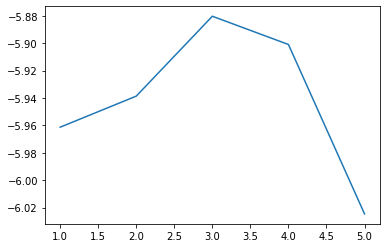

In [ ]:
plt.plot([i for i in range(1,6)],perplexity_list)


Text(0, 0.5, 'Coherence (C_v)')

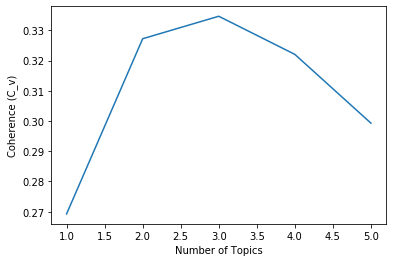

In [ ]:
plt.plot([i for i in range(1,6)],coherence_list)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence (C_v)")

From the graph above, modelling coherence with the corresponding number of topics, we can see that the coherence is highest at 3 topics, i.e. the model performs best for that number of topics, and the themes are the most distinguishable from each other.

### 5.3 Model creation

We can now proceed to model the topics, knowing that there are 3 distinct topics in the corpus

In [ ]:
# Plotting tools configuration
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\sklearn\decomposition\online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

                                           
# Print the Keyword in each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"free" + 0.028*"stock" + 0.024*"account" + 0.018*"trade" + '
  '0.017*"invest" + 0.016*"open" + 0.014*"financi" + 0.012*"secur" + '
  '0.012*"market" + 0.012*"brokerag"'),
 (1,
  '0.053*"trade" + 0.035*"start" + 0.033*"invest" + 0.028*"today" + '
  '0.019*"account" + 0.016*"dream" + 0.013*"wait" + 0.012*"open" + '
  '0.012*"power" + 0.012*"stop"'),
 (2,
  '0.054*"invest" + 0.031*"stock" + 0.017*"free" + 0.016*"share" + '
  '0.016*"trade" + 0.015*"commiss" + 0.012*"account" + 0.011*"protect" + '
  '0.010*"start" + 0.009*"market"')]


The output above shows the keywords that are most informative in defining each topic

In [ ]:
print("Model characteristics")

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Model characteristics

Perplexity:  -5.880288305196637

Coherence Score:  0.3346437980466867


In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

C:\Users\joyji\Anaconda3\envs\myenv\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.083826  0.067149       1        1  36.810928
2      0.030142 -0.092164       2        1  35.130195
1     -0.113968  0.025015       3        1  28.058878, topic_info=         Term       Freq      Total Category  logprob  loglift
204     trade  48.000000  48.000000  Default  30.0000  30.0000
188     start  28.000000  28.000000  Default  29.0000  29.0000
257      free  29.000000  29.000000  Default  28.0000  28.0000
45      dream   8.000000   8.000000  Default  27.0000  27.0000
201     today  23.000000  23.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
29    commiss   5.239818  21.881458   Topic3  -4.5662  -0.1585
125    market   3.836126  17.435757   Topic3  -4.8780  -0.2432
214      want   3.107989   9.031212   Topic3  -5.0885   0.2042
101  investor   3.115921  10.608854   Topic3  -5.0859   0.0457
63    financi   3.118443  16.001614   Topic3  -5.0851  -0.3645

[194 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
224       1  0.863887   access
224       2  0.143981   access
0         1  0.491817  account
0         2  0.215170  account
0         3  0.307385  account
...     ...       ...      ...
221       2  0.450273     work
221       3  0.450273     work
222       2  0.802047    world
222       3  0.267349    world
441       2  0.885129   wouldn

[226 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [ ]:
# pyLDAvis.save_html(vis, 'lda.html') # saving the model locally

Using the visual interface displayed above, we can fine tune the hyperparameter lambda to find the value at which the topics are the most distinct and the keyowrds are the most informative of each topic. At lambda = 0.3, the three main themes seem to be:
* Aspiration words: dream, start, power, wait, today, stop
* Wealth in the long term: invest, share; capital, build, protect, long, simple, term, choose
* Financial products and services: free, claim, secure, brokerage, nasdaq, crypto